In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## 1

In [4]:
def find_best_split(feature_vector, target_vector):
    def mean_len(x):
        return np.mean(x), len(x)
    n = len(feature_vector)
    uniq_f = list(set(feature_vector))
    uniq_f.sort()
    thresholds = [(x + y) / 2 for x,y in zip(uniq_f[: len(uniq_f) - 1], uniq_f[1:])]
    p1_right = [mean_len([target_vector[x[0]] for x in enumerate(feature_vector) if x[1] > thre]) for thre in thresholds]
    p1_left = [mean_len([target_vector[x[0]] for x in enumerate(feature_vector) if x[1] <= thre]) for thre in thresholds]
    ginis = [-1/n*(x[1]*(1 - x[0] ** 2 - (1 - x[0]) ** 2) + y[1]*(1 - y[0] ** 2 - (1 - y[0]) ** 2)) for x,y in zip(p1_right,p1_left)]
    if not ginis :
        return []
    else : 
        return thresholds, ginis, thresholds[ginis.index(max(ginis))], max(ginis)
    

In [5]:
import pandas as pd
students = pd.read_csv('students.csv')

In [53]:
data_st = students.drop(' UNS', axis = 1)
target_vector = students[' UNS'].values

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


## 2

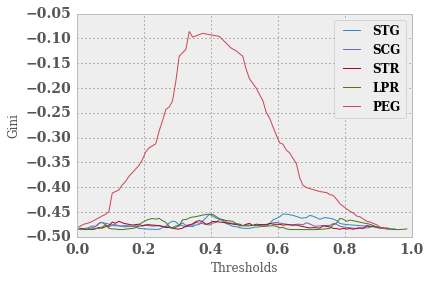

In [76]:
ax =plt.subplots()
for col in data_st.columns :
    ans = find_best_split(data_st[str(col)].values, target_vector)
    ax = plt.plot(ans[0], ans[1], label = str(col))
plt.xlabel('Thresholds')
plt.ylabel('Gini')
plt.grid(True)
plt.legend(loc = 0)
plt.show()

Исходя из графиков, разбиение выборки лучше производить по признаку PEG. Кривая для этого признака имеет ярковыраженный максимум, при том один. Кривая для "хорошего" признака должна быть унимодальна и ее максимум должен быть ярко выражен, то есть график должен быть похож на вогную функцию. Кривая для признакоы, по которым деление почти невозможно выглядит как константа, без ярковыраженных пиков, например все признаки кроме PEG на графике выше.

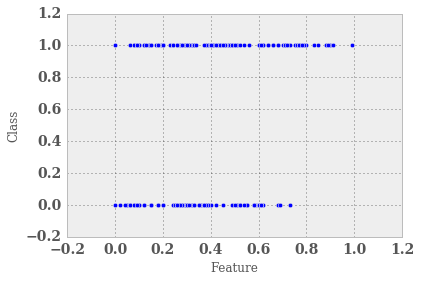

In [77]:
plt.scatter(data_st['STG'].values, target_vector)
plt.xlabel('Feature')
plt.ylabel('Class')
plt.grid(True)
plt.legend(loc = 0)
plt.show()

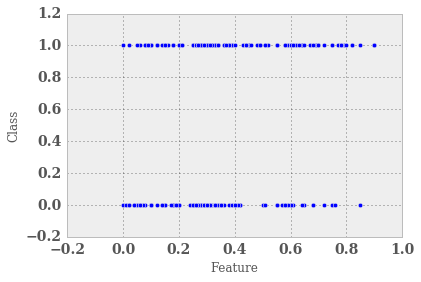

In [78]:
plt.scatter(data_st['SCG'].values, target_vector)
plt.xlabel('Feature')
plt.ylabel('Class')
plt.grid(True)
plt.legend(loc = 0)
plt.show()

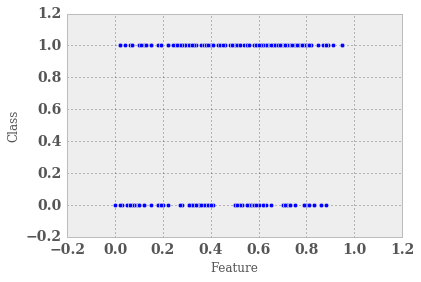

In [79]:
plt.scatter(data_st['STR'].values, target_vector)
plt.xlabel('Feature')
plt.ylabel('Class')
plt.grid(True)
plt.legend(loc = 0)
plt.show()

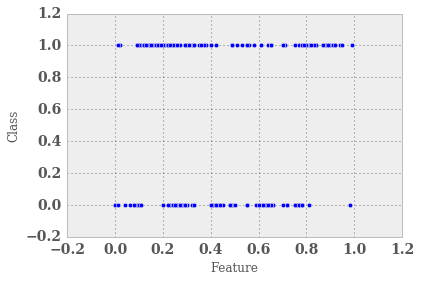

In [80]:
plt.scatter(data_st['LPR'].values, target_vector)
plt.xlabel('Feature')
plt.ylabel('Class')
plt.grid(True)
plt.legend(loc = 0)
plt.show()

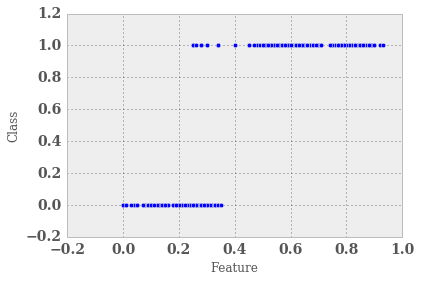

In [81]:
plt.scatter(data_st['PEG'].values, target_vector)
plt.xlabel('Feature')
plt.ylabel('Class')
plt.grid(True)
plt.legend(loc = 0)
plt.show()

## 3

Scatter графики согласуются с графиками значения критерия Джини. Объекты хорошо разделяются по признаку PEG, анпример с порогом 0.4. Для остальных признаков этого увидеть нельзя.

## 4

In [5]:
from sklearn.base import BaseEstimator

class DecisionTree(BaseEstimator):
    def __init__(self, types, target, X):
        def categorial(feature_vector, target_vector) :
            uniq_f = list(set(feature_vector))
            value_list = [(np.mean([target_vector[x[0]] for x in enumerate(feature_vector) if x[1] == uniq]), uniq) for uniq in uniq_f]
            value_list.sort(key = lambda item : item[0])
            value_list = [x[1] for x in value_list]
            exch = {x : value_list.index(x) for x in value_list}
            return exch
        
        self._tree = []
        self.types = types
        self.fit_target = target
        self.translate = {}
        
        for i in range(X.shape[1]) :
             if self.types[i] == 1 :
                change = categorial(X[:, i], self.fit_target)
                self.translate[i] = change
                X[:, i] = np.array([change.get(x) for x in list(X[:, i])])
        
        
        
    def preprocessing(self, X) :
        for i in range(X.shape[1]) :
            if self.types[i] == 1 :
                X[:, i] = np.array([self.translate.get(i).get(x) for x in list(X[:, i])])
        return X
    

    def fit(self, X, y):        
        
        def fit_node(subX, suby, node):
            if len(set(suby)) == 1 :
                node.append(suby[0])
                return None
            else :
                
                feature_res = [(i,find_best_split(subX[:, i], suby)) for i in range(subX.shape[1])]
                feature_res = [(feature_res[i][0], feature_res[i][1][2], feature_res[i][1][3]) for i in range(len(feature_res)) if len(feature_res[i][1]) > 0]
                feature_res.sort(key = lambda item : item[2])
                node.extend((feature_res[-1][0],feature_res[-1][1], [], []))
                right_list = [x[0] for x in enumerate(subX[:,node[0]]) if x[1] > node[1]]
                left_list = [x[0] for x in enumerate(subX[:,node[0]]) if x[1] <= node[1]]
                fit_node(subX[left_list, :], suby[left_list],node[2])
                fit_node(subX[right_list, :], suby[right_list],node[3])
                return None
          
        fit_node(X, y, self._tree)
        
    def predict(self, X):
        def predict_node(x, node):
            if len(node) == 1 :
                return node[0]
            else : 
                return predict_node(x,node[3]) if x[node[0]] > node[1] else predict_node(x, node[2]) 
            
        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)

## 5

In [6]:
aga = pd.read_csv('agaricus-lepiota.csv')

In [7]:
aga.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [9]:
for col in aga.columns :
    le.fit(aga[str(col)].values.tolist())
    aga[str(col) + '_new'] = le.transform(aga[str(col)].values.tolist())
    aga.drop(str(col), axis = 1, inplace = True)
aga.head()

,p_new,x_new,s_new,n_new,t_new,p.1_new,f_new,c_new,n.1_new,k_new,...,s.2_new,w_new,w.1_new,p.2_new,w.2_new,o_new,p.3_new,k.1_new,s.3_new,u_new
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [10]:
y = aga.p_new.values
X = aga.drop('p_new', axis = 1)
for col in X.columns :
    if len(set(X[str(col)].values)) == 1 :
        X.drop(str(col), axis = 1, inplace = True)

In [11]:
from sklearn.cross_validation import train_test_split
X_ = X.values
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.5, random_state=42)

In [12]:
tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)

In [13]:
tree.fit(X_train,y_train)

In [14]:
X_test = tree.preprocessing(X_test)

In [15]:
ans = tree.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, ans))

1.0


Accuracy = 1.0.

## 6

In [14]:
tic_tac = pd.read_csv('tic-tac-toe.csv')
car = pd.read_csv('car.csv')
nursery = pd.read_csv('nursery.csv')

In [15]:
tic_tac.positive = tic_tac.positive.apply(lambda t : 1 if t == 'positive' else 0)
tic_tac.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,1
1,x,x,x,x,o,o,o,o,x,1
2,x,x,x,x,o,o,o,b,b,1
3,x,x,x,x,o,o,b,o,b,1
4,x,x,x,x,o,o,b,b,o,1


In [16]:
car.unacc = car.unacc.apply(lambda t : 0 if t in {'unacc', 'acc'} else 1)
car.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,0
1,vhigh,vhigh,2,2,small,high,0
2,vhigh,vhigh,2,2,med,low,0
3,vhigh,vhigh,2,2,med,med,0
4,vhigh,vhigh,2,2,med,high,0


In [17]:
nursery.recommend = nursery.recommend.apply(lambda t : 0 if t in {'not_recom', 'recom'} else 1)
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,1
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,0
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,1
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,1
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,0


In [18]:
tic_tac_target = tic_tac.positive.values
tic_tac.drop('positive', axis = 1, inplace = True)
for col in tic_tac.columns :
    le.fit(tic_tac[str(col)].values.tolist())
    tic_tac[str(col)] = le.transform(tic_tac[str(col)].values.tolist())

car_target = car.unacc.values
car.drop('unacc', axis = 1, inplace = True)
for col in car.columns :
    le.fit(car[str(col)].values.tolist())
    car[str(col)] = le.transform(car[str(col)].values.tolist())

nursery_target = nursery.recommend.values
nursery.drop('recommend', axis = 1, inplace = True)
for col in nursery.columns :
    le.fit(nursery[str(col)].values.tolist())
    nursery[str(col)] = le.transform(nursery[str(col)].values.tolist())

# Сравнение методов

In [52]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

print('TIC-TAC')
enc = OneHotEncoder(sparse = False)
X = tic_tac.values
X_train, X_test, y_train, y_test = train_test_split(X, tic_tac_target, test_size=0.3)

tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all real accuracy = ',metrics.accuracy_score(y_test, ans))

tree = DecisionTree(np.ones(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all factor accuracy = ',metrics.accuracy_score(y_test, ans))

clf = DecisionTreeClassifier()
predicted = cross_val_predict(clf, X, tic_tac_target, cv=10)
print('sklearn tree accuracy = ',metrics.accuracy_score(tic_tac_target, predicted))

enc = OneHotEncoder(sparse = False)
X = tic_tac.values
enc.fit(X)
X = enc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, tic_tac_target, test_size=0.3, random_state=228)
tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all real + OneHot accuracy = ',metrics.accuracy_score(y_test, ans))

TIC-TAC
all real accuracy =  0.909722222222
all factor accuracy =  0.930555555556
sklearn tree accuracy =  0.725182863114
all real + OneHot accuracy =  0.944444444444


In [53]:
print('CAR')
enc = OneHotEncoder(sparse = False)
X = car.values
X_train, X_test, y_train, y_test = train_test_split(X, car_target, test_size=0.3)

tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all real accuracy = ',metrics.accuracy_score(y_test, ans))

tree = DecisionTree(np.ones(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all factor accuracy = ',metrics.accuracy_score(y_test, ans))

clf = DecisionTreeClassifier()
predicted = cross_val_predict(clf, X, car_target, cv=10)
print('sklearn tree accuracy = ',metrics.accuracy_score(car_target, predicted))

enc = OneHotEncoder(sparse = False)
X = car.values
enc.fit(X)
X = enc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, car_target, test_size=0.3)
tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all real + OneHot accuracy = ',metrics.accuracy_score(y_test, ans))

CAR
all real accuracy =  0.992292870906
all factor accuracy =  0.992292870906
sklearn tree accuracy =  0.940938042849
all real + OneHot accuracy =  0.969171483622


In [55]:
print('NURSERY')
enc = OneHotEncoder(sparse = False)
X = nursery.values
X_train, X_test, y_train, y_test = train_test_split(X, nursery_target, test_size=0.3)

tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all real accuracy = ',metrics.accuracy_score(y_test, ans))

tree = DecisionTree(np.ones(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all factor accuracy = ',metrics.accuracy_score(y_test, ans))

clf = DecisionTreeClassifier()
predicted = cross_val_predict(clf, X, nursery_target, cv=10)
print('sklearn tree accuracy = ',metrics.accuracy_score(nursery_target, predicted))

enc = OneHotEncoder(sparse = False)
X = nursery.values
enc.fit(X)
X = enc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, nursery_target, test_size=0.3)
tree = DecisionTree(np.zeros(len(y_train)), y_train, X_train)
tree.fit(X_train,y_train)
X_test = tree.preprocessing(X_test)
ans = tree.predict(X_test)
print('all real + OneHot accuracy = ',metrics.accuracy_score(y_test, ans))

NURSERY
all real accuracy =  1.0
all factor accuracy =  1.0
sklearn tree accuracy =  1.0
all real + OneHot accuracy =  1.0


## 7

Из эксперимента видно, что алгоритмы ранжируются по-разному на различных наборах данных. К примеру на 'tic-tac' лучшим оказалось OneHot-кодирование и все признаки вещественные, а на 'car' лучшими оказались алгоритмы где все признаки считаются либо просто вещественными либо просто категориальными.

В датасете tic-tac мне показалось странным, что распределния крестиков и ноликов в фиксированной ячейке неодинакова, возможно если удлить из датасета строки, сравняв доли крестиков и нолиуов в ячейках, можно улучшить результат.

## 8

In [99]:
wine = pd.read_csv('winequality-red.csv')

In [100]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [101]:
target = wine.quality
wine.drop('quality', axis = 1, inplace = True)

In [102]:
from sklearn.cross_validation import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [103]:
clf = DecisionTreeClassifier()
predicted = cross_val_predict(clf, wine, target, cv=3)
print('DecisionTreeClassifier accuracy = ',metrics.accuracy_score(target, predicted))

clf = BaggingClassifier(n_estimators = 100)
predicted = cross_val_predict(clf, wine, target, cv=3)
print('BaggingClassifier accuracy = ',metrics.accuracy_score(target, predicted))

clf = BaggingClassifier(n_estimators = 100, max_features = 0.5)
predicted = cross_val_predict(clf, wine, target, cv=3)
print('BaggingClassifier max_f = 0.5 accuracy = ',metrics.accuracy_score(target, predicted))

clf = RandomForestClassifier()
predicted = cross_val_predict(clf, wine, target, cv=3)
print('RandomForestClassifier accuracy = ',metrics.accuracy_score(target, predicted))

DecisionTreeClassifier accuracy =  0.447154471545
BaggingClassifier accuracy =  0.55784865541
BaggingClassifier max_f = 0.5 accuracy =  0.550969355847
RandomForestClassifier accuracy =  0.512820512821


## 9

In [117]:
wine = pd.read_csv('winequality-red.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [118]:
wine = wine.reindex(np.random.permutation(wine.index))
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1448,6.9,0.580,0.01,1.9,0.080,40.0,54.0,0.99683,3.40,0.73,9.7,5
1063,10.2,0.290,0.65,2.4,0.075,6.0,17.0,0.99565,3.22,0.63,11.8,6
237,7.2,0.645,0.00,1.9,0.097,15.0,39.0,0.99675,3.37,0.58,9.2,6
641,9.5,0.590,0.44,2.3,0.071,21.0,68.0,0.99920,3.46,0.63,9.5,5
272,10.9,0.370,0.58,4.0,0.071,17.0,65.0,0.99935,3.22,0.78,10.1,5


In [119]:
target = wine.quality
wine.drop('quality', axis = 1, inplace = True)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(wine, target, test_size=0.3, random_state=42)

In [129]:
clf = RandomForestClassifier(warm_start=True)
acc = []
for n_est in range(10, 5001, 10) :
    clf.set_params(n_estimators = n_est)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, predicted))

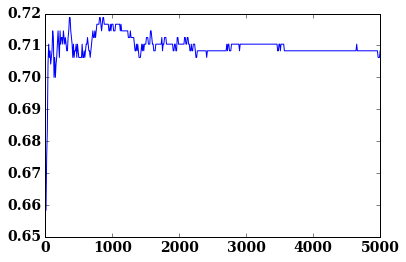

In [134]:
plt.plot(range(10,5001,10), acc)
plt.show()

С ростом числа деревьев accuracy стабилизируется у значения примерно 0.71. Следовательно с увеличением числа деревьев случайный лес не переобучается.